In [2]:
#google colab file
#Created by ashutoshtiwari13
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from sample_data.replay_buffer import ReplayBuffer


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [5]:
#Cartpole environment
env = gym.make("CartPole-v0")

In [6]:
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.4):
        super(NoisyLinear, self).__init__()
        
        self.in_features  = in_features
        self.out_features = out_features
        self.std_init     = std_init
        
        self.weight_mu    = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.FloatTensor(out_features, in_features))
        
        self.bias_mu    = nn.Parameter(torch.FloatTensor(out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        self.register_buffer('bias_epsilon', torch.FloatTensor(out_features))
        
        self.reset_parameters()
        self.reset_noise()
    
    def forward(self, x):
        if self.training: 
            weight = self.weight_mu + self.weight_sigma.mul(Variable(self.weight_epsilon))
            bias   = self.bias_mu   + self.bias_sigma.mul(Variable(self.bias_epsilon))
        else:
            weight = self.weight_mu
            bias   = self.bias_mu
        
        return F.linear(x, weight, bias)
    
    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.weight_mu.size(1))
        
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.weight_sigma.size(1)))
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.bias_sigma.size(0)))
    
    def reset_noise(self):
        epsilon_in  = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(self._scale_noise(self.out_features))
    
    def _scale_noise(self, size):
        x = torch.randn(size)
        x = x.sign().mul(x.abs().sqrt())
        return x

In [7]:
class QRDQN(nn.Module):
    def __init__(self, num_inputs, num_actions, num_quants):
        super(QRDQN, self).__init__()
        
        self.num_inputs  = num_inputs
        self.num_actions = num_actions
        self.num_quants  = num_quants
        
        self.features = nn.Sequential(
            nn.Linear(num_inputs, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_actions * self.num_quants)
        )

        
    def forward(self, x):
        batch_size = x.size(0)

        x = self.features(x)
        x = x.view(batch_size, self.num_actions, self.num_quants)
        
        return x
    
    def q_values(self, x):
        x = self.forward(x)
        return x.mean(2)
    
    def reset_noise(self):
        self.noisy_value1.reset_noise()
        self.noisy_value2.reset_noise() 
        
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = Variable(torch.FloatTensor(np.array(state, dtype=np.float32)).unsqueeze(0), volatile=True)
            qvalues = self.forward(state).mean(2)
            action  = qvalues.max(1)[1]
            action  = action.data.cpu().numpy()[0]
        else:
            action = random.randrange(self.num_actions)
        return action

In [8]:
def projection_distribution(dist, next_state, reward, done):
    next_dist = target_model(next_state)
    next_action = next_dist.mean(2).max(1)[1]
    next_action = next_action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_quant)
    next_dist = next_dist.gather(1, next_action).squeeze(1).cpu().data

    expected_quant = reward.unsqueeze(1) + 0.99 * next_dist * (1 - done.unsqueeze(1))
    expected_quant = Variable(expected_quant)

    quant_idx = torch.sort(dist, 1, descending=False)[1]

    tau_hat = torch.linspace(0.0, 1.0 - 1./num_quant, num_quant) + 0.5 / num_quant
    tau_hat = tau_hat.unsqueeze(0).repeat(batch_size, 1)
    quant_idx = quant_idx.cpu().data
    batch_idx = np.arange(batch_size)
    tau = tau_hat[:, quant_idx][batch_idx, batch_idx]
        
    return tau, expected_quant

In [9]:
num_quant = 51
Vmin = -10
Vmax = 10

current_model = QRDQN(env.observation_space.shape[0], env.action_space.n, num_quant)
target_model  = QRDQN(env.observation_space.shape[0], env.action_space.n, num_quant)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(10000)

In [10]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
    
update_target(current_model, target_model)

In [27]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size) 

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(np.float32(done))

    dist = current_model(state)
    action = action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_quant)
    dist = dist.gather(1, action).squeeze(1)
    
    tau, expected_quant = projection_distribution(dist, next_state, reward, done)
    u= expected_quant-dist
    k = 1
    
    
    huber_loss = 0.5 * u.abs().clamp(min=0.0, max=k).pow(2)
    huber_loss += k * (u.abs() -  u.abs().clamp(min=0.0, max=k))
    quantile_loss = (tau - (u < 0).float()).abs() * huber_loss
    loss = quantile_loss.sum() / num_quant
        
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm(current_model.parameters(), 0.5)
    optimizer.step()
    
    return loss

In [12]:
def plot(frame_idx, rewards, losses):
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [13]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [14]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


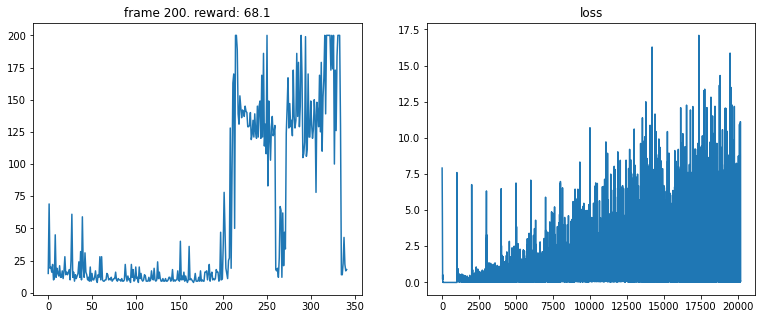

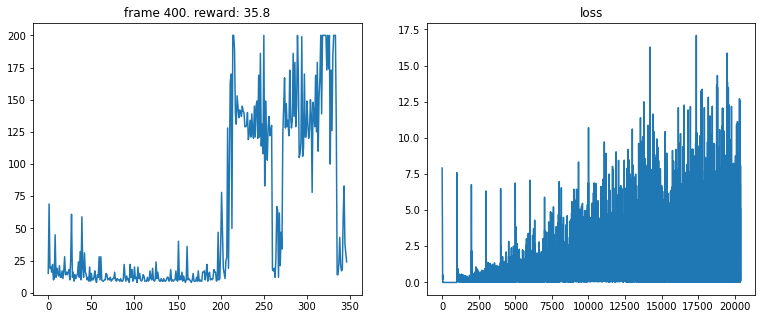

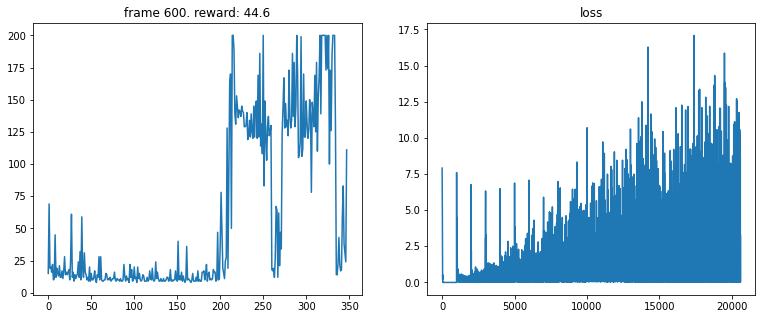

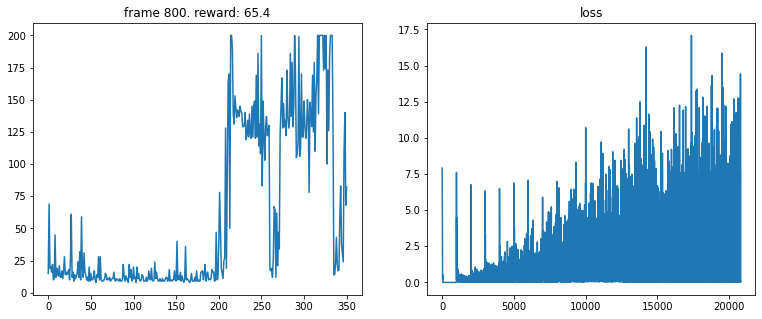

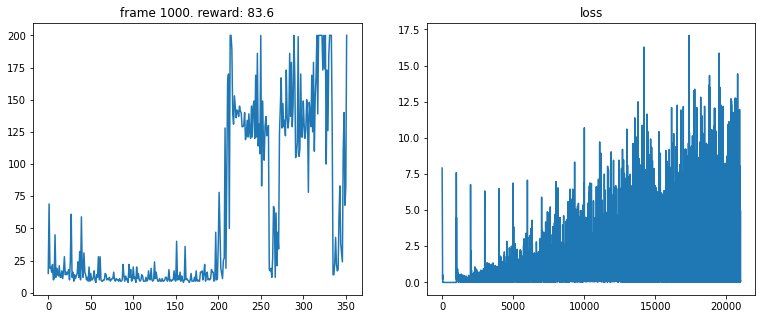

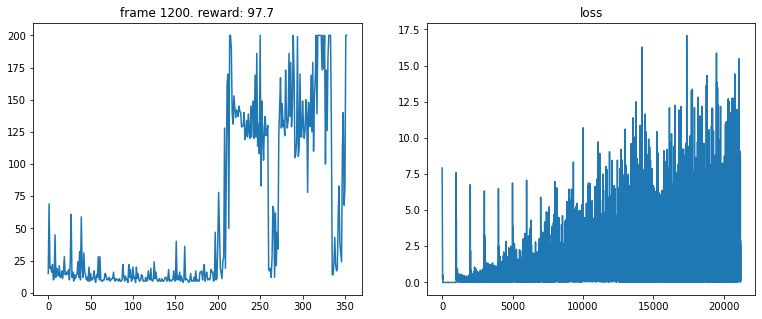

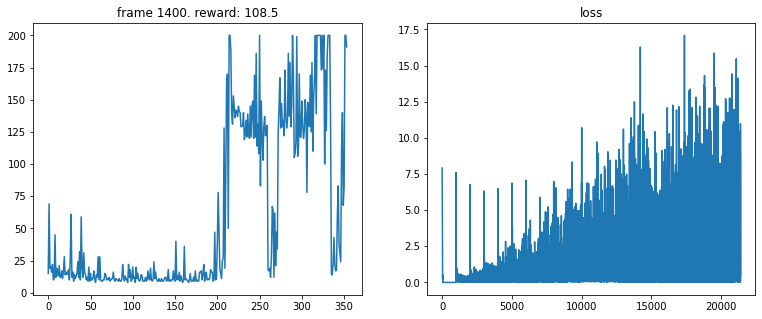

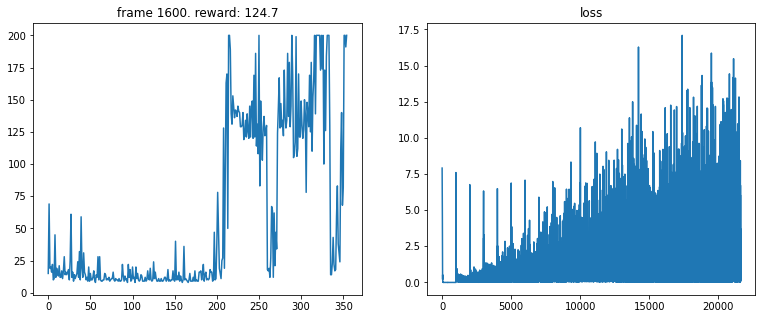

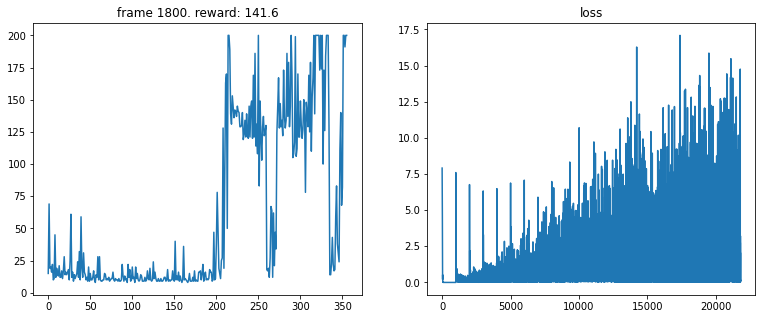

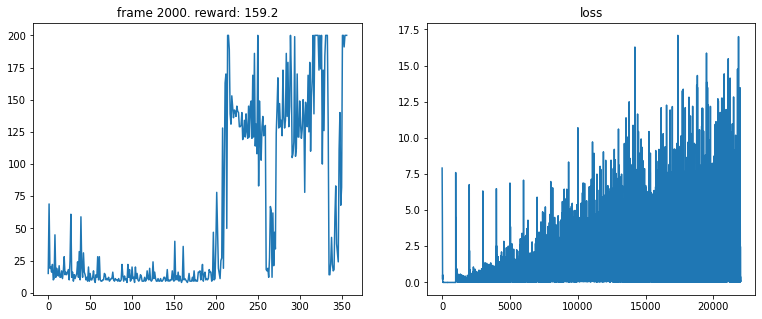

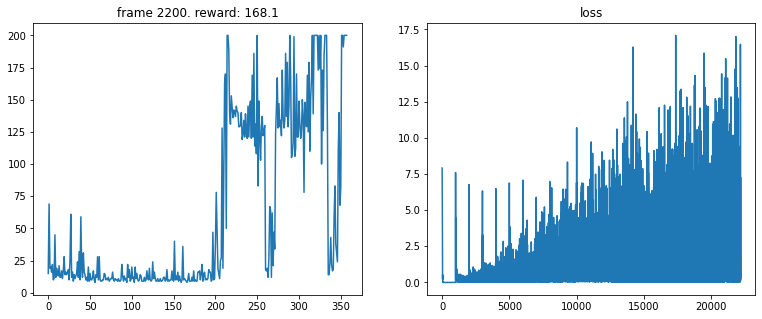

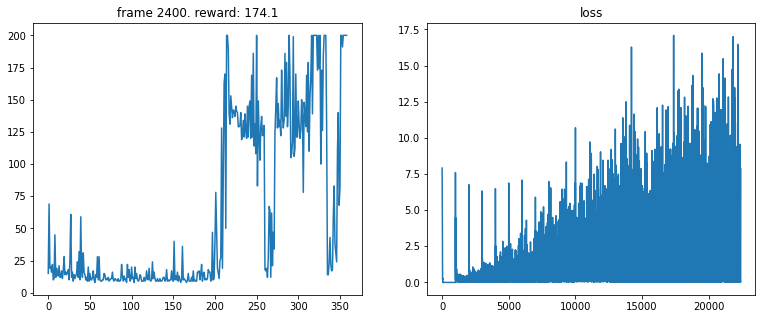

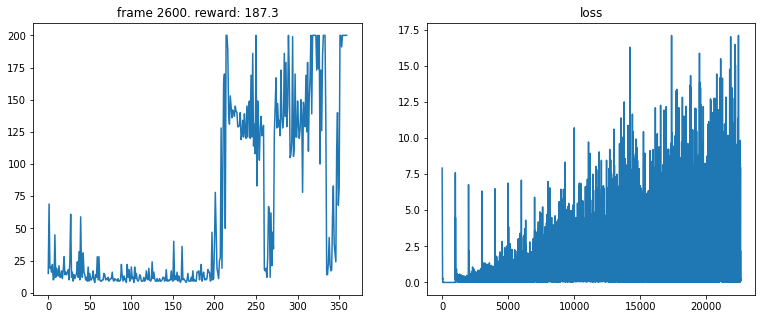

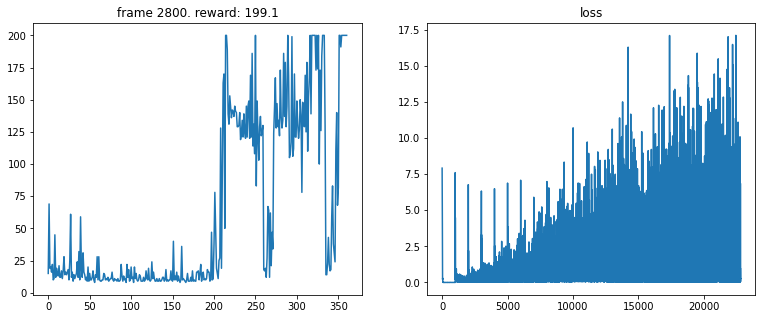

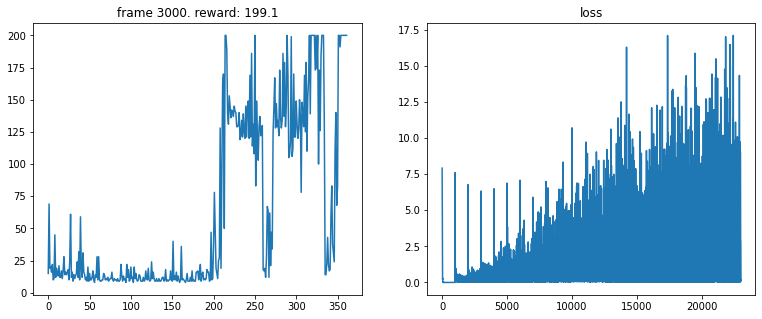

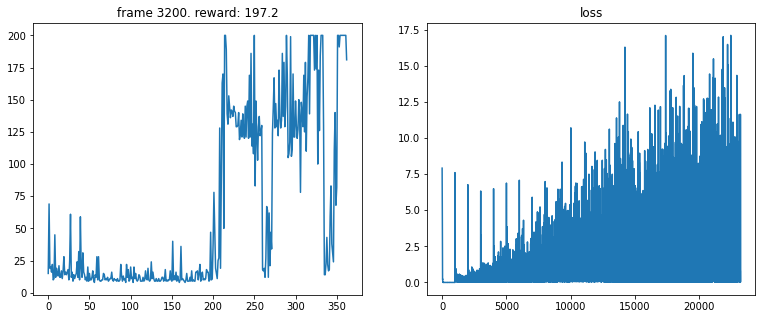

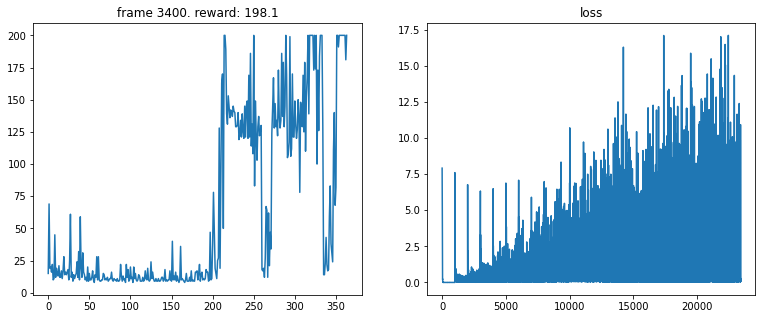

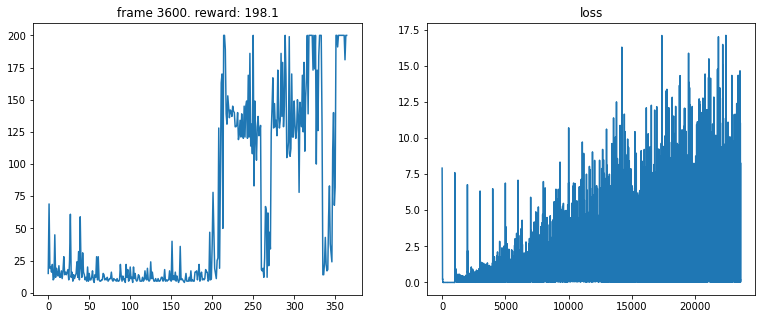

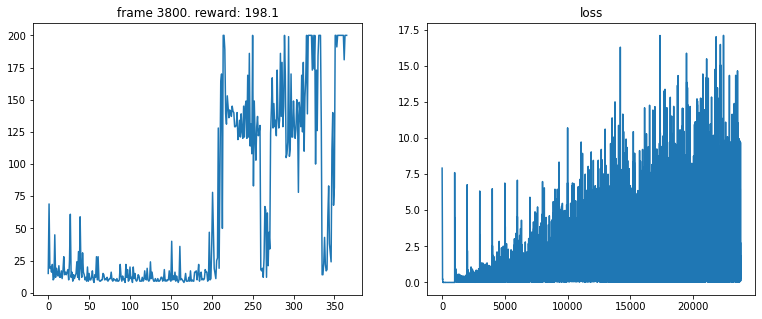

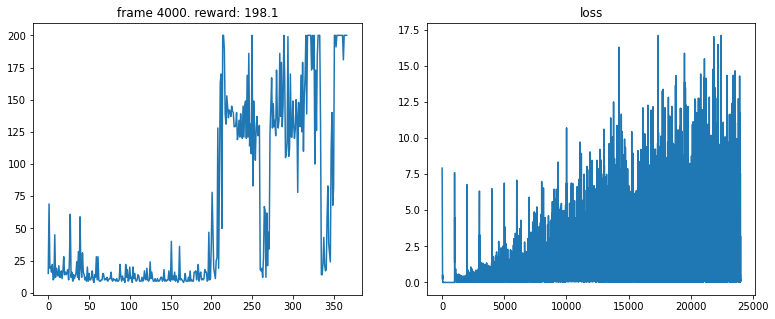

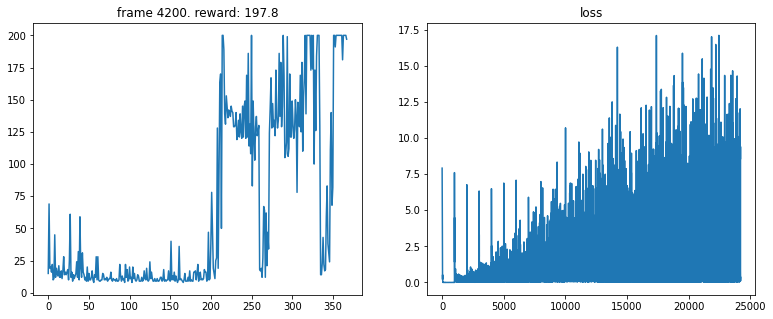

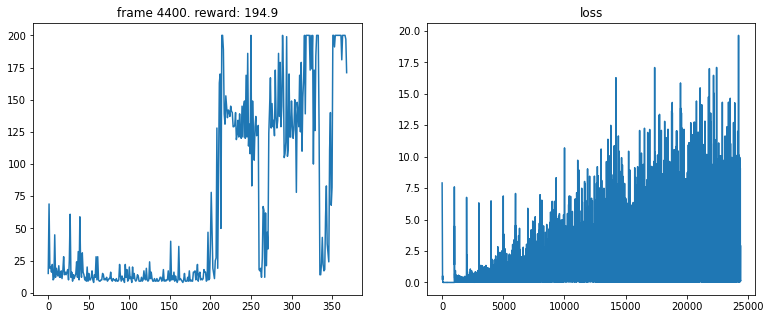

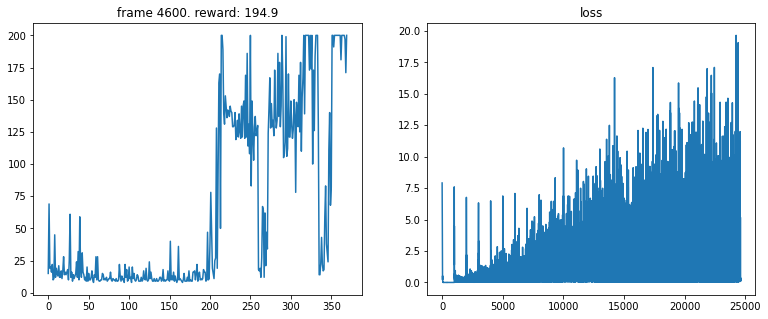

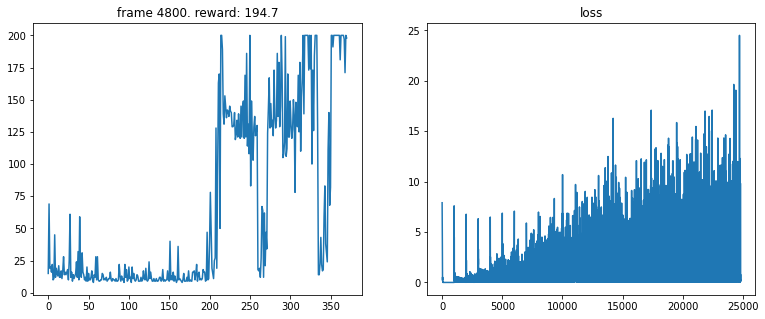

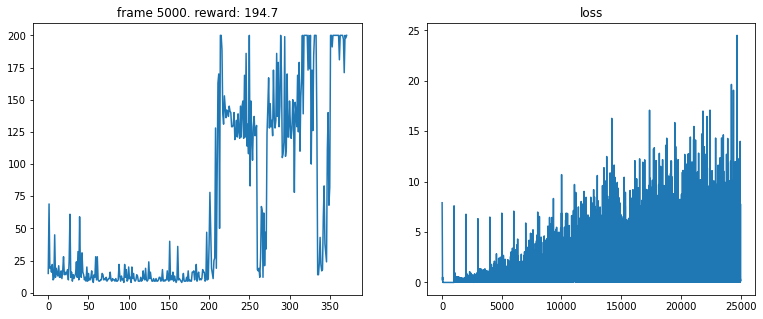

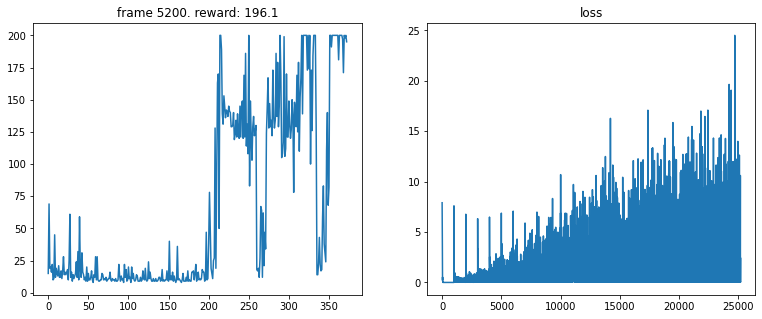

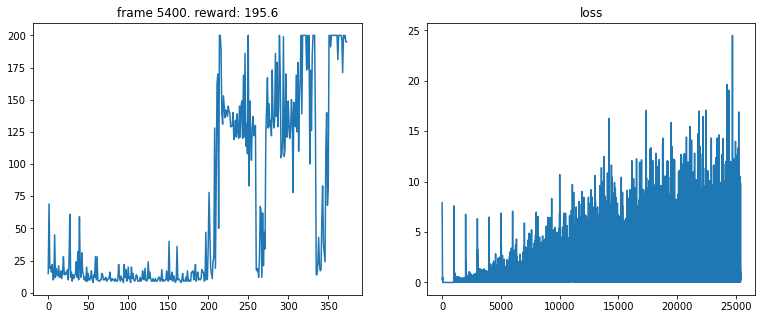

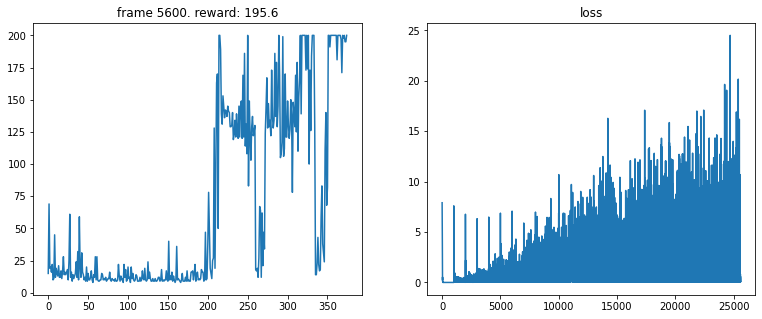

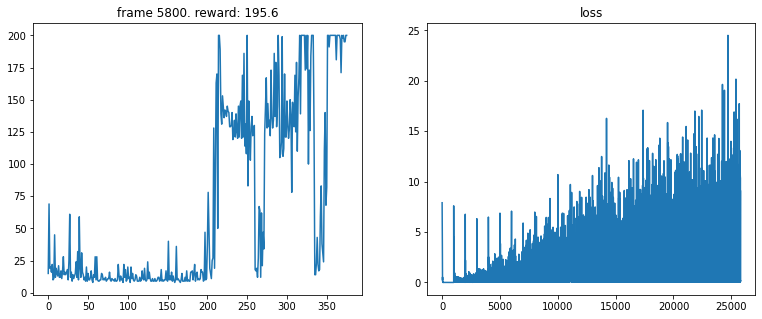

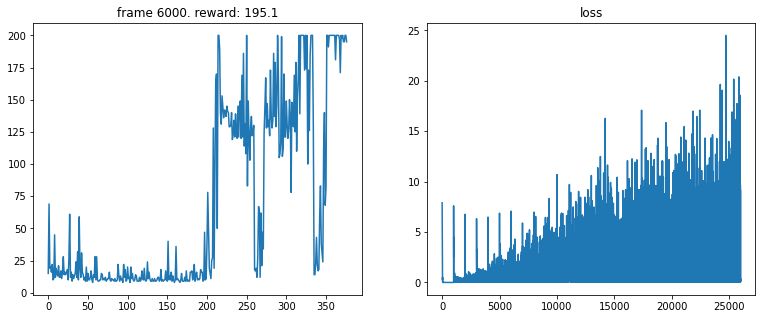

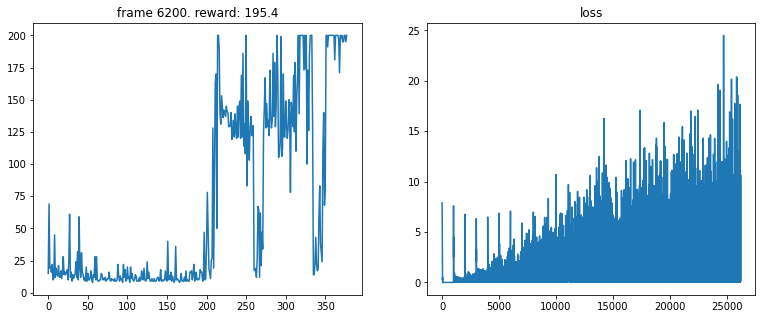

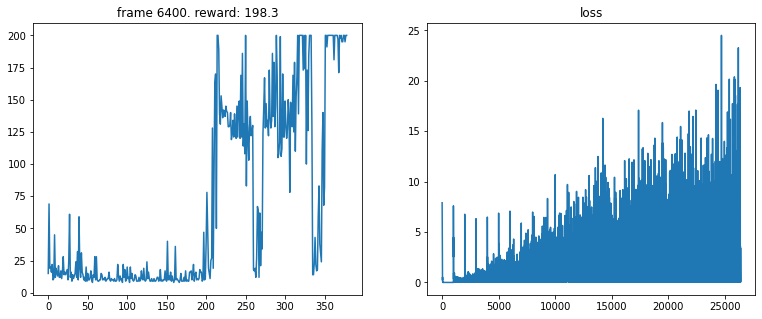

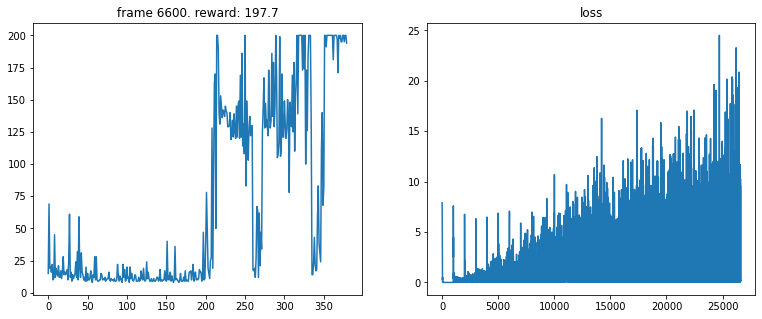

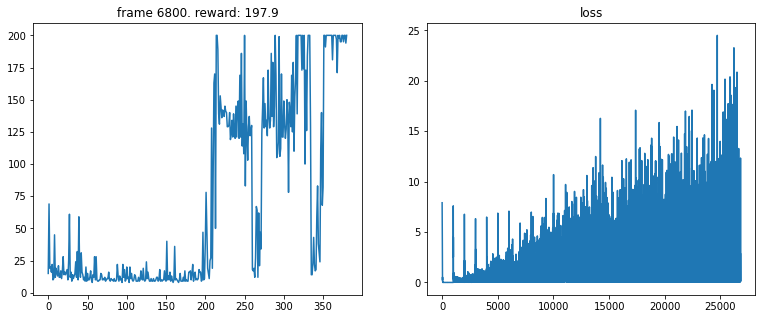

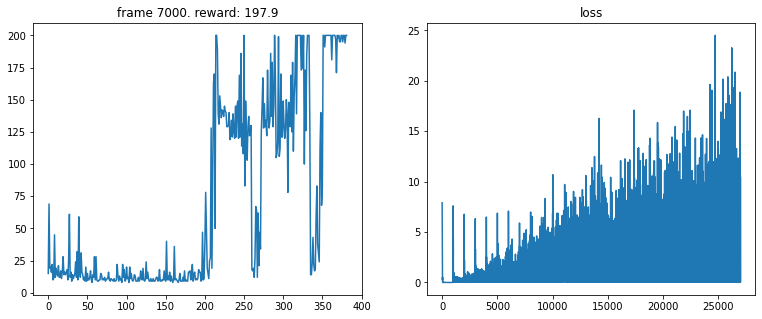

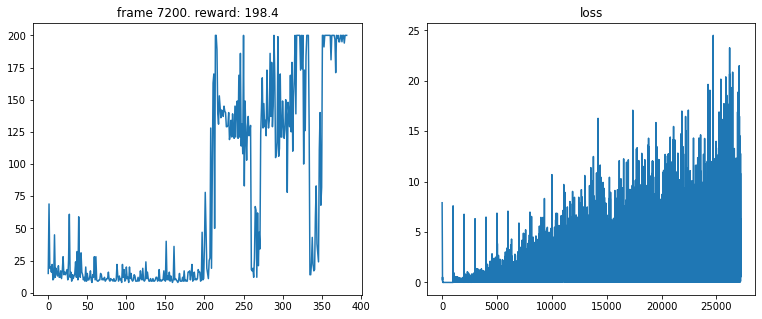

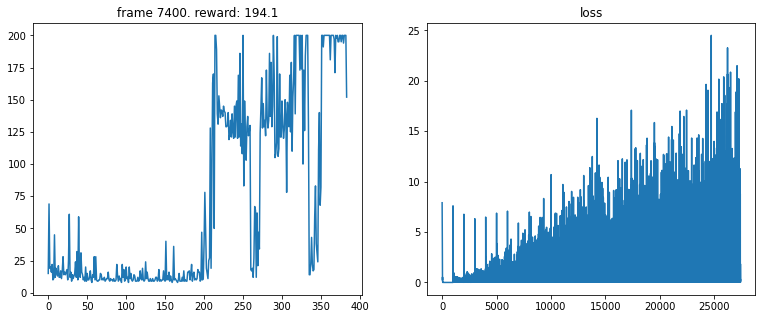

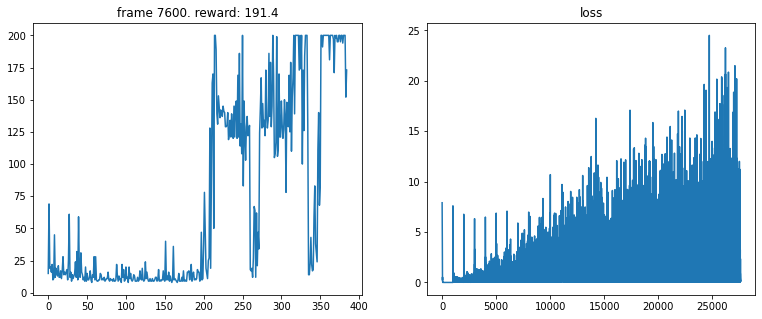

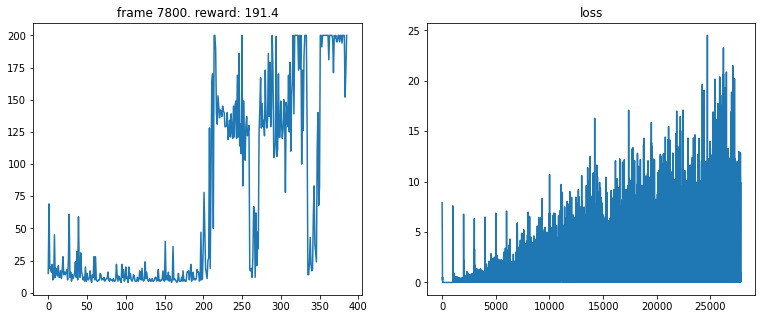

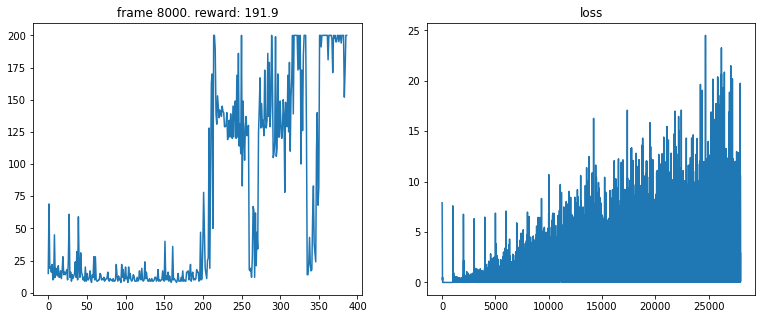

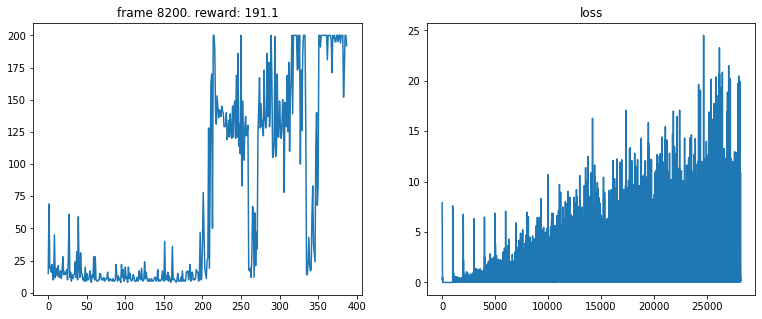

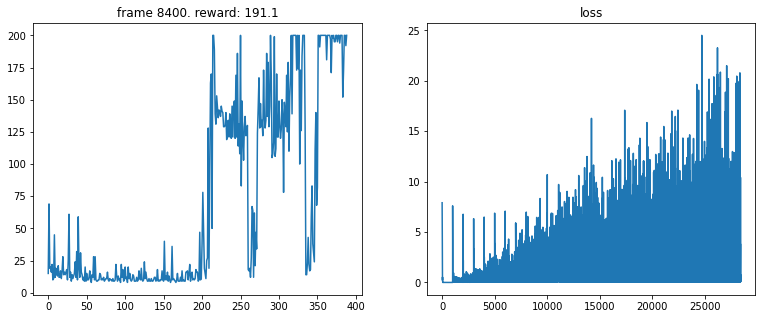

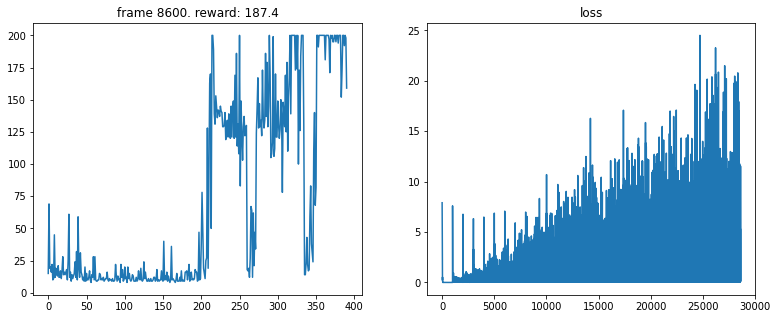

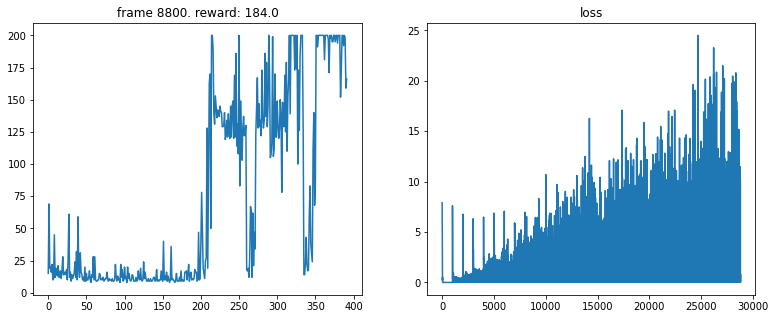

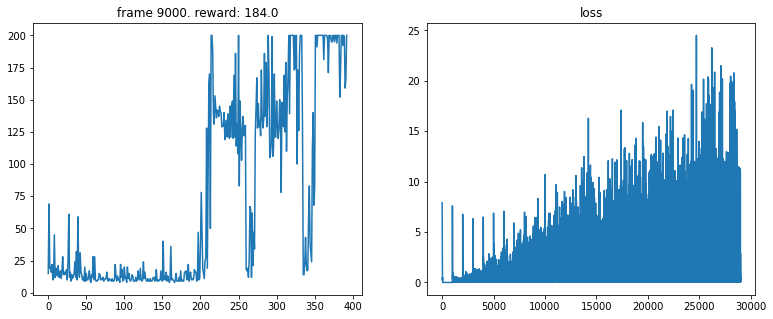

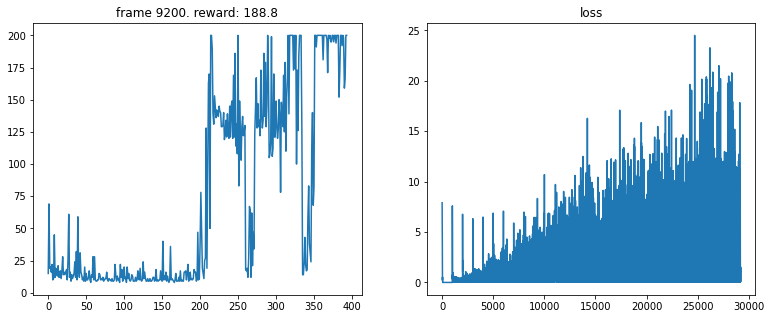

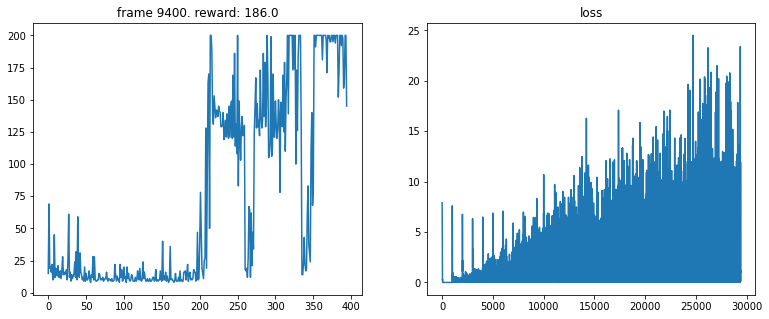

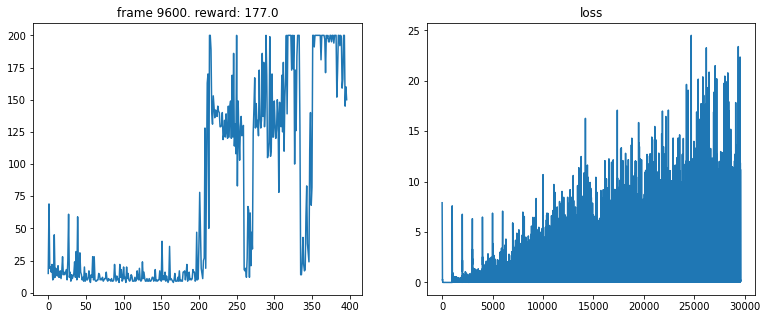

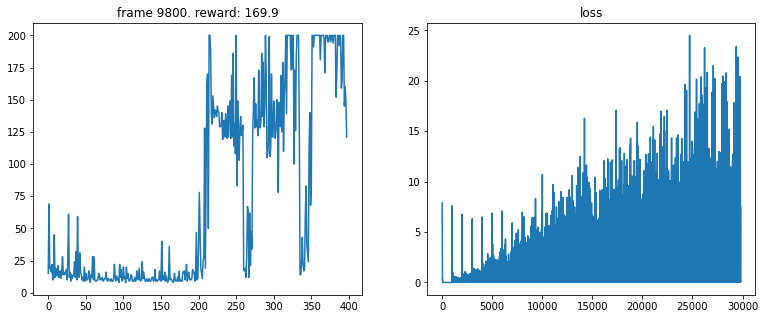

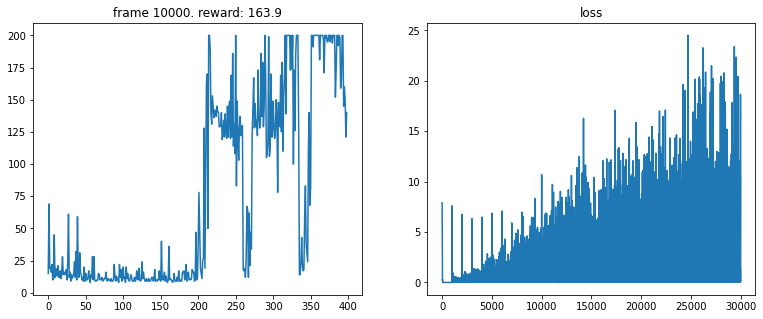

In [29]:
state = env.reset()
for frame_idx in range(1, num_frames + 1):
    action = current_model.act(state, epsilon_by_frame(frame_idx))
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)